# SFig.3 — Clustering with IMF1, IMF2, and IMF1+2 (EEMD)

This supplementary notebook reproduces clustering using CEEMDAN/EEMD components:
- IMF1 only
- IMF2 only
- IMF1 + IMF2

It reads `Data_mid/*_EEMD.parquet`, computes station-wise feature vectors, applies clustering, and plots side-by-side station maps. Results are saved to `Output/`.

In [1]:
# Imports and paths
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

DATA_DIR = Path('../Data')
MID_DIR = Path('../Data_mid')
FINAL_DIR = Path('../Data_final')
OUTPUT_DIR = Path('../Output')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

N_CLUSTERS = 3  # adjust if needed


In [2]:
# Station list from monthly files to ensure consistent naming
monthly_files = sorted([p for p in DATA_DIR.glob('Monthly_*.txt')])
stations = [p.stem.replace('Monthly_', '') for p in monthly_files]
len(stations), stations[:5]  # quick peek


(21, ['Anheung', 'Boryeong', 'Busan', 'Chujado', 'Gadeokdo'])

In [3]:
# Load station coordinates from total_results.csv (assumes columns: station name, latitude, longitude)
meta = pd.read_csv(FINAL_DIR / 'total_results.csv')
meta = meta.rename(columns={
    'station name':'station', 'Station name':'station',
    'Latitude':'latitude','Longitude':'longitude'
})
coords = meta[['station','latitude','longitude']].dropna()
coords = coords[coords['station'].isin(stations)]
coords.shape, coords.head()


((21, 3),
      station   latitude   longitude
 0      Mokpo  34.779722  126.375556
 1    Anheung  36.673611  126.132222
 2  Tongyeong  34.827500  128.434722
 3      Yeosu  34.747222  127.765556
 4  Heuksando  34.683889  125.436389)

In [7]:
df = pd.read_csv('../Data_final/total_results_2048_0.6.csv', index_col=0)
df = df.sort_values('station name')

import geopandas as gpd

df_geo = gpd.read_file('/Data/Backup//Data/Geo/sido_20240213/ctp_rvn.shp', encoding='euc-kr')
geog = df_geo.to_crs(epsg=4326)


In [4]:
def load_eemd_series(station: str) -> pd.DataFrame:
    p = MID_DIR / f'{station}_CEEMDAN_2048_0.6.parquet'
    if not p.exists():
        return None
    try:
        df = pd.read_parquet(p)
    except Exception as e:
        print('Failed to load', p, e)
        return None
    # Expect IMF_0, IMF_1, ... columns; keep only those
    imf_cols = [c for c in df.columns if str(c).startswith('IMF_')]
    return df[imf_cols]

def make_features(df: pd.DataFrame, mode: str) -> np.ndarray:
    # Build 1D time series according to mode
    if mode == 'imf1':
        if 'IMF_1' not in df.columns: return None
        x = df['IMF_1'].values
    elif mode == 'imf2':
        if 'IMF_2' not in df.columns: return None
        x = df['IMF_2'].values
    elif mode == 'imf12':
        for c in ['IMF_1','IMF_2']:
            if c not in df.columns: return None
        x = (df['IMF_1'] + df['IMF_2']).values
    elif mode == 'all':
        x = (df.sum(axis=1)).values
    else:
        raise ValueError('unknown mode')
    # de-mean by first value as in main text
    if len(x) == 0 or np.isnan(x).all():
        return None
    return x - x[0]

def build_matrix(stations, mode: str):
    series = {}
    for s in stations:
        df = load_eemd_series(s)
        if df is None: continue
        x = make_features(df, mode)
        if x is None: continue
        series[s] = x
    # Align by truncating to min length across stations
    if not series: return None, []
    L = min(len(v) for v in series.values())
    names = sorted(series.keys())
    X = np.vstack([series[n][:L] for n in names])
    return X, names

def cluster_kmeans(X, n_clusters=N_CLUSTERS, seed=0):
    km = KMeans(n_clusters=n_clusters, random_state=seed, n_init='auto')
    labels = km.fit_predict(X)
    return labels


# def cluster


def get_clusters_for_modes(stations, modes=('imf1','imf2','imf12', 'all')):
    out = {}
    ref_names = None
    for m in modes:
        X, names = build_matrix(stations, m)
        if X is None or X.shape[0] < N_CLUSTERS:
            out[m] = ([], [])
            continue
        labels = cluster_kmeans(X, N_CLUSTERS)
        out[m] = (names, labels, X)
        if ref_names is None: ref_names = names
    return out

clusters = get_clusters_for_modes(stations)
# {k: (len(v[0]), set(v[0])) for k,v in clusters.items()}


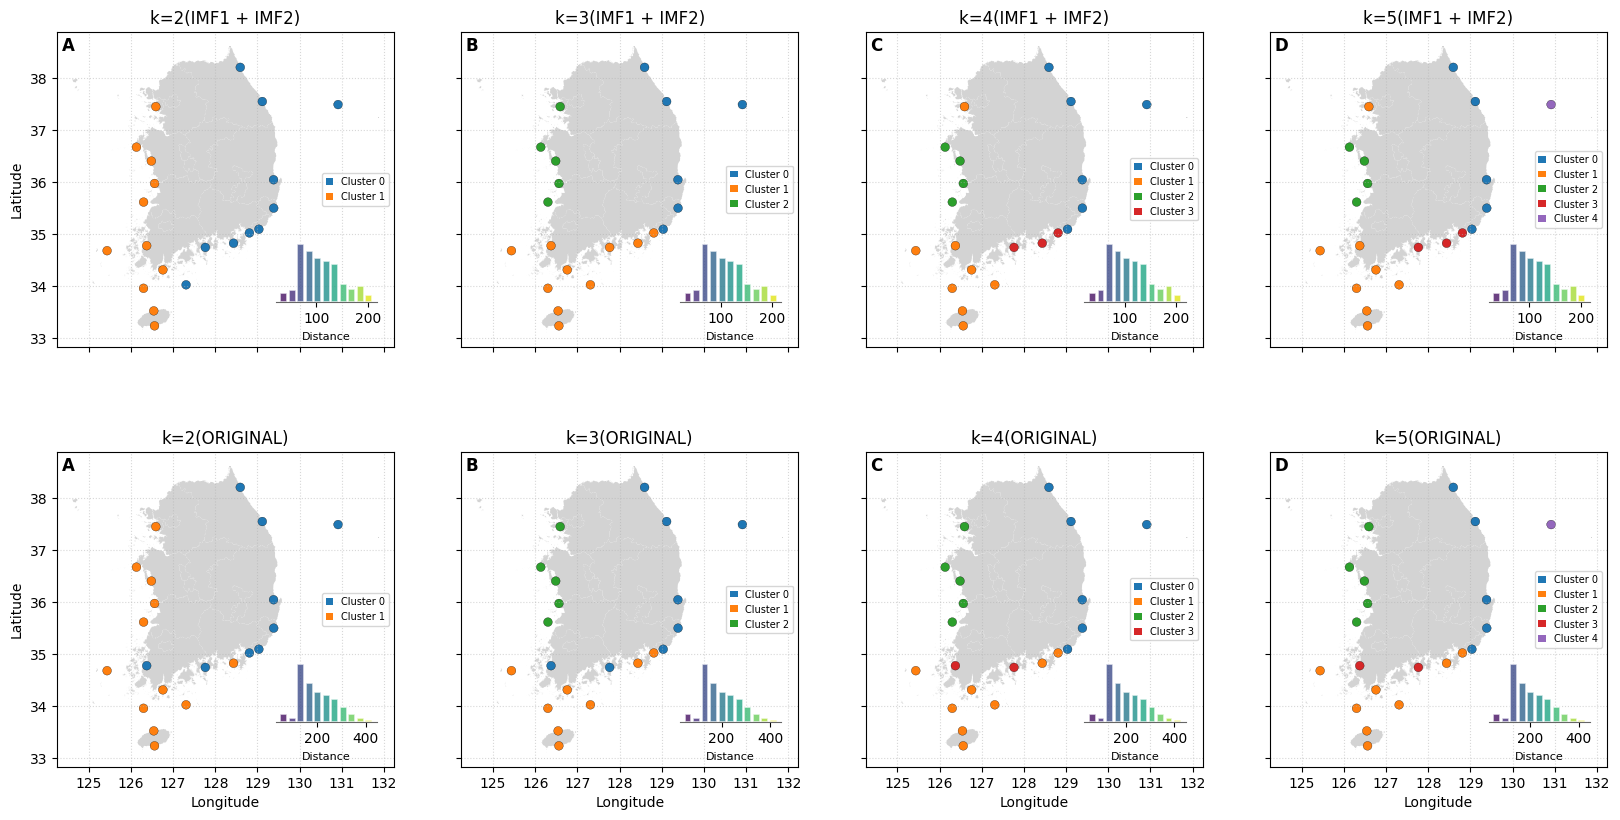

In [9]:
import string
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Assemble plotting dataframe
plot_df = coords.copy()
mode = 'imf12'
for N_CLUSTERS in [2, 3, 4, 5]:
    clusters = get_clusters_for_modes(stations)
    names, labels, X = clusters.get(mode, ([], [], []))
    lab_map = {n:int(l) for n,l in zip(names, labels)}
    plot_df[f'cluster_{N_CLUSTERS}'] = plot_df['station'].map(lab_map)

_n_clusters = [(2, 'k=2'), (3, 'k=3'), (4, 'k=4'), (5, 'k=5')]
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()
for axi, (ax, (key, title)) in enumerate(zip(axes[:4], _n_clusters)):
    ax.text(.014, .94, string.ascii_uppercase[axi], transform=ax.transAxes,
        size=12, weight='bold')

     # plot geo
    geog.plot(ax=ax, color='lightgrey', alpha=1.)
    col = f'cluster_{key}'
    dfp = plot_df.dropna(subset=[col])
    sc = ax.scatter(dfp['longitude'], dfp['latitude'], c=dfp[col].astype(int), cmap='tab10', vmin=0, vmax=10, s=40, edgecolor='k', linewidths=.2)

    from matplotlib.patches import Patch
    # 고유한 클러스터 값들과 개수 확인
    unique_clusters = sorted(set(dfp[col].astype(int)))
    n_clusters = len(unique_clusters)
    
    # tab10 colormap에서 색상 추출
    cmap = plt.cm.tab10
    colors = [cmap(i) for i in range(n_clusters)]
    
    # Legend elements 생성
    legend_elements = [Patch(facecolor=colors[i], label=f'Cluster {cluster}') 
                       for i, cluster in enumerate(unique_clusters)]
    
    # Legend 추가
    ax.legend(handles=legend_elements, 
              loc='center right',  # 또는 원하는 위치
              fontsize=7, handlelength=.8
             )

    
    ax.set_title(title+'(IMF1 + IMF2)')
    ax.grid(True, ls=':', alpha=.5)
    ax.set_xlabel('')


    # ── 여기서 subax 추가 ──
    # 메인 ax 기준으로 inset axes 생성 (조금 위로 이동)
    subax = inset_axes(ax,
                       width="30%",    # width = 30% of parent_bbox
                       height="30%",   # height = 30% of parent_bbox
                       loc='lower right',  # lower right -> upper right로 변경
                       bbox_to_anchor=(-.03, 0.12, 1, .65),  # (x0, y0, width, height)
                       bbox_transform=ax.transAxes,)
    
    # 히스토그램 데이터 준비
    from scipy.spatial.distance import pdist, squareform
    import numpy as np
    
    # X는 (n_samples, n_features) 형태
    X = clusters[mode][2]
    dist = pdist(X, metric='euclidean').flatten()
    bins = np.linspace(min(dist), max(dist), 12)
    n, bins_edges, patches = subax.hist(dist,
                         bins=bins,
                         rwidth=0.8,
                         alpha=0.8,
                         edgecolor='white',
                         linewidth=1.2, zorder=2)
    
    # 그라디언트 색상 적용
    import matplotlib.colors as mcolors
    # norm = mcolors.Normalize(vmin=0, vmax=1)  # 실제 데이터 범위로 수정
    norm = mcolors.Normalize(vmin=min(dist), vmax=max(dist))  # 실제 데이터 범위로 수정
    cmap = plt.cm.viridis
    
    # 각 bin의 중앙값 계산
    bin_centers = 0.5 * (bins_edges[:-1] + bins_edges[1:])
    
    # 패치 색상 설정
    for patch, center in zip(patches, bin_centers):
        patch.set_facecolor(cmap(norm(center)))
    
    # 스타일링
    subax.set_facecolor('none')
    for spine in ['top', 'right', 'left']:
        subax.spines[spine].set_visible(False)
    subax.spines['bottom'].set_color('#666666')
    
    # 라벨/틱 설정
    subax.set_xlabel('Distance', fontsize=8)
    subax.set_yticks([])
    
axes[0].set_ylabel('Latitude')

plot_df = coords.copy()
mode = 'all'
for N_CLUSTERS in [2, 3, 4, 5]:
    clusters = get_clusters_for_modes(stations)
    names, labels, X = clusters.get(mode, ([], [], []))
    lab_map = {n:int(l) for n,l in zip(names, labels)}
    plot_df[f'cluster_{N_CLUSTERS}'] = plot_df['station'].map(lab_map)

for axi, (ax, (key, title)) in enumerate(zip(axes[4:], _n_clusters)):
    ax.text(.014, .94, string.ascii_uppercase[axi], transform=ax.transAxes,
        size=12, weight='bold')

     # plot geo
    geog.plot(ax=ax, color='lightgrey', alpha=1.)
    col = f'cluster_{key}'
    dfp = plot_df.dropna(subset=[col])
    sc = ax.scatter(dfp['longitude'], dfp['latitude'], c=dfp[col].astype(int), cmap='tab10', vmin=0, vmax=10, s=40, edgecolor='k', linewidths=.2)

    from matplotlib.patches import Patch
    # 고유한 클러스터 값들과 개수 확인
    unique_clusters = sorted(set(dfp[col].astype(int)))
    n_clusters = len(unique_clusters)
    
    # tab10 colormap에서 색상 추출
    cmap = plt.cm.tab10
    colors = [cmap(i) for i in range(n_clusters)]
    
    # Legend elements 생성
    legend_elements = [Patch(facecolor=colors[i], label=f'Cluster {cluster}') 
                       for i, cluster in enumerate(unique_clusters)]
    
    # Legend 추가
    ax.legend(handles=legend_elements, 
              loc='center right',  # 또는 원하는 위치
              fontsize=7, handlelength=.8
             )

    
    ax.set_title(title+'(ORIGINAL)')
    ax.grid(True, ls=':', alpha=.5)
    ax.set_xlabel('Longitude')


    # ── 여기서 subax 추가 ──
    # 메인 ax 기준으로 inset axes 생성 (조금 위로 이동)
    subax = inset_axes(ax,
                       width="30%",    # width = 30% of parent_bbox
                       height="30%",   # height = 30% of parent_bbox
                       loc='lower right',  # lower right -> upper right로 변경
                       bbox_to_anchor=(-.03, 0.12, 1, .65),  # (x0, y0, width, height)
                       bbox_transform=ax.transAxes,)
    
    # 히스토그램 데이터 준비
    from scipy.spatial.distance import pdist, squareform
    import numpy as np
    
    # X는 (n_samples, n_features) 형태
    X = clusters[mode][2]
    dist = pdist(X, metric='euclidean').flatten()
    bins = np.linspace(min(dist), max(dist), 12)
    n, bins_edges, patches = subax.hist(dist,
                         bins=bins,
                         rwidth=0.8,
                         alpha=0.8,
                         edgecolor='white',
                         linewidth=1.2, zorder=2)
    
    # 그라디언트 색상 적용
    import matplotlib.colors as mcolors
    # norm = mcolors.Normalize(vmin=0, vmax=1)  # 실제 데이터 범위로 수정
    norm = mcolors.Normalize(vmin=min(dist), vmax=max(dist))  # 실제 데이터 범위로 수정
    cmap = plt.cm.viridis
    
    # 각 bin의 중앙값 계산
    bin_centers = 0.5 * (bins_edges[:-1] + bins_edges[1:])
    
    # 패치 색상 설정
    for patch, center in zip(patches, bin_centers):
        patch.set_facecolor(cmap(norm(center)))
    
    # 스타일링
    subax.set_facecolor('none')
    for spine in ['top', 'right', 'left']:
        subax.spines[spine].set_visible(False)
    subax.spines['bottom'].set_color('#666666')
    
    # 라벨/틱 설정
    subax.set_xlabel('Distance', fontsize=8)
    subax.set_yticks([])
    
axes[4].set_ylabel('Latitude')


fig.savefig('../Output/SFig7_param_sweep_clustering.pdf', dpi=300, bbox_inches='tight')

In [35]:
# Assemble plotting dataframe
plot_df = coords.copy()
for mode in ['imf1','imf2','imf12', 'all']:
    names, labels, X = clusters.get(mode, ([], [], []))
    lab_map = {n:int(l) for n,l in zip(names, labels)}
    plot_df[f'cluster_{mode}'] = plot_df['station'].map(lab_map)

plot_df.head()


,station,latitude,longitude,cluster_imf1,cluster_imf2,cluster_imf12,cluster_all
0,Mokpo,34.779722,126.375556,3,0,1,3
1,Anheung,36.673611,126.132222,2,3,2,2
2,Tongyeong,34.827500,128.434722,3,3,3,1
3,Yeosu,34.747222,127.765556,3,1,3,3
4,Heuksando,34.683889,125.436389,3,3,1,1


In [ ]:
import leidenalg as la

n_imf=2
ress = []
for n_imf in [999, 12, 23, 123, 0, 1, 2, -1]:
    res = []
    for THRESHOLD in np.linspace(0,1,21):
        _res = []
        for resolution in np.linspace(0,1,21):
            G = get_graph(NUM_IMF=n_imf, THRESHOLD=THRESHOLD, Zero=1e-6)
            partition = la.find_partition(G, la.RBConfigurationVertexPartition, 
                                                resolution_parameter=resolution, seed=42)
            n_clst = len(set(partition.membership))
            
            # cluster = get_clusters_for_modes()
            # partition = get_cluster3(NUM_IMF=n_imf, THRESHOLD=THRESHOLD, Zero=1e-5)
            # n_clst = len(set(partition))
            _res.append(n_clst)
        res.append(_res)
    ress.append(res)
        # print(resolution, len(set(partition.membership)))

In [ ]:
import matplotlib.colors as colors


# 파라미터 조합 테스트
imf_configs = [999, 12, 23, 123, 0, 1, 2, -1]
imf_labels = ['All', 'IMF1+2', 'IMF2+3', 'IMF1+2+3', 'IMF1', 'IMF2', 'IMF3', 'Last']


n_clusters = 5
cmap = plt.cm.viridis
bounds = np.arange(0.5, n_clusters + 1.5, 1)  # [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

# 2행 4열 시각화
fig, axes = plt.subplots(2, 4, figsize=(16, 7), dpi=150)
axes = axes.flatten()

for i, (imf_config, imf_label) in enumerate(zip(imf_configs, imf_labels)):
    ax = axes[i]
    
    # Heatmap 생성
    im = ax.imshow(ress[i], aspect='auto', cmap='viridis', norm=norm,
                   extent=[0, 1.0, 0., 1.], origin='lower')
    
    # 컬러바 추가
    cbar = plt.colorbar(im, ax=ax, shrink=0.8, spacing='proportional', ticks=[1, 2, 3, 4, 5])
    cbar.set_ticklabels(['1', '2', '3', '4', '5+'])
    cbar.set_label('# Clusters', rotation=270, labelpad=15)
    
    # 축 레이블과 제목
    ax.set_xlabel('Resolution Parameter')
    ax.set_ylabel('Threshold')
    ax.set_title(f'{imf_label}')
    
    # 그리드 추가
    ax.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('Output/clustering_parameter_sweep.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
df = pd.read_csv('./Data_final/total_results_2048_0.6.csv', index_col=0)
df = df.sort_values('station name')

import geopandas as gpd

df_geo = gpd.read_file('/Data/Backup//Data/Geo/sido_20240213/ctp_rvn.shp', encoding='euc-kr')
geog = df_geo.to_crs(epsg=4326)


In [14]:
from tqdm import tqdm

path = 'Data/'
flist = sorted([x for x in os.listdir('./Data/')if x.endswith('txt')])

df_oris = []
for f in tqdm(flist):
    df_ori = pd.read_csv(path+f, sep='\t', header=None)
    df_oris.append(df_ori)

df_ress = []
for f in tqdm(flist):
    df_res = pd.read_parquet(f'Data_mid/{f[8:-4]}_CEEMDAN_2048_0.6.parquet')
    df_ress.append(df_res)


df_ress2 = []
for f in tqdm(flist):
    df_res = pd.read_parquet(f'Data_mid/{f[8:-4]}_EEMD_2048_0.6.parquet')
    df_ress2.append(df_res)

100%|██████████| 21/21 [00:00<00:00, 801.71it/s]


In [15]:
corrs = []
corrs.append(get_corr_tidal(df_oris, 1, 0))
corrs.append(get_corr_tidal(df_ress, 'IMF_0'))
corrs.append(get_corr_tidal(df_ress, 'last'))

100%|██████████| 21/21 [00:00<00:00, 180.32it/s]


In [24]:
# def get_cluster3(NUM_IMF=-1, THRESHOLD=0.3, Zero=1e-5):
#     limfs = []
#     stations = []
#     for i, df_res in enumerate(df_ress):
#         if NUM_IMF == 999:
#             limfs.append(df_res.iloc[:,:].sum(axis=1) - df_res.iloc[0,:].sum())
#         elif NUM_IMF == 12:
#             limfs.append(df_res.iloc[:,:2].sum(axis=1) - df_res.iloc[0,:2].sum())
#         elif NUM_IMF == 123:
#             limfs.append(df_res.iloc[:,:3].sum(axis=1) - df_res.iloc[0,:3].sum())
#         elif NUM_IMF == 23:
#             limfs.append(df_res.iloc[:,1:3].sum(axis=1) - df_res.iloc[0,:1:3].sum())
#         else:
#             limfs.append(df_res.iloc[:,NUM_IMF] - df_res.iloc[0,NUM_IMF])
#         stations.append(flist[i][8:-4])
    
#     _df = pd.concat(limfs, axis=1)
#     _df.columns = stations
    
#     X = _df.dropna()
    
#     # 상관관계 매트릭스 계산
#     corr_matrix = X.corr()
    
#     # DataFrame을 numpy array로 변환
#     adjMat = corr_matrix.abs().values
#     adjMat[adjMat < THRESHOLD] = 0
#     np.fill_diagonal(adjMat, 0)
#     # return adjMat
    
#     import igraph as ig
#     import leidenalg as la
    
#     # vertex names를 명시적으로 설정
#     G = ig.Graph.Weighted_Adjacency(adjMat, mode="undirected", attr='weight', loops=False)
#     G.vs['name'] = list(X.T.index)  # station names 추가
#     # return G
    
#     # partition = la.find_partition(G, la.ModularityVertexPartition)
#     min_clusters = 5
#     partition = None
    
#     for res in np.linspace(0.0001, .01, 200):  # 범위는 상황에 맞게 조정
#         partition = la.find_partition(
#             G, 
#             la.RBConfigurationVertexPartition, 
#             resolution_parameter=res
#         )
#         if len(set(partition.membership)) >= min_clusters:
#             print(f"resolution={res}, clusters={len(set(partition.membership))}")
#             break
    
#     # station 이름과 cluster를 매핑
#     cluster_dict = dict(zip(G.vs['name'], partition.membership))
#     # print(cluster_dict)
    
#     # 원래 순서대로 cluster 정보 반환
#     membs = [cluster_dict[station] for station in stations]
    
#     return G, membs

def get_graph(NUM_IMF=-1, THRESHOLD=0.3, Zero=1e-5):
    limfs = []
    stations = []
    for i, df_res in enumerate(df_ress):
        if NUM_IMF == 999:
            limfs.append(df_res.iloc[:,:].sum(axis=1) - df_res.iloc[0,:].sum())
        elif NUM_IMF == 12:
            limfs.append(df_res.iloc[:,:2].sum(axis=1) - df_res.iloc[0,:2].sum())
        elif NUM_IMF == 123:
            limfs.append(df_res.iloc[:,:3].sum(axis=1) - df_res.iloc[0,:3].sum())
        elif NUM_IMF == 23:
            limfs.append(df_res.iloc[:,1:3].sum(axis=1) - df_res.iloc[0,:1:3].sum())
        else:
            limfs.append(df_res.iloc[:,NUM_IMF] - df_res.iloc[0,NUM_IMF])
        stations.append(flist[i][8:-4])
    
    _df = pd.concat(limfs, axis=1)
    _df.columns = stations
    
    X = _df.dropna()
    
    # 상관관계 매트릭스 계산
    corr_matrix = X.corr()
    
    # DataFrame을 numpy array로 변환
    adjMat = corr_matrix.abs().values
    adjMat[adjMat < THRESHOLD] = 0
    np.fill_diagonal(adjMat, 0)
    # return adjMat
    
    import igraph as ig
    import leidenalg as la
    
    # vertex names를 명시적으로 설정
    G = ig.Graph.Weighted_Adjacency(adjMat, mode="undirected", attr='weight', loops=False)
    G.vs['name'] = list(X.T.index)  # station names 추가
    
    return G


def get_corr_tidal(dfs, target_col, date_col="none"):
    def get_last_col(_df):
        _ = _df[_df.columns[-1]]
        _.columns = ['last']
        return _
    n_station = len(dfs)
    res = []
    if date_col == "none":
        
        for i in tqdm(range(n_station)):
            if target_col == "last":
                df_i = get_last_col(dfs[i])
            else:
                df_i = dfs[i][[target_col]]
            for j in range(i+1, n_station):
                if target_col == "last":
                    df_j = get_last_col(dfs[j])
                else:
                    df_j = dfs[j][[target_col]]
                df_ = pd.merge(df_i ,df_j, left_index=True, right_index=True, suffixes=('_i', '_j'))
                corr = df_.corr()
                res.append(corr.iloc[0,1])        
    else:
        for i in tqdm(range(n_station)):
            df_i = dfs[i][[target_col, date_col]]
            for j in range(i+1, n_station):
                df_j = dfs[j][[target_col, date_col]]
                df_ = pd.merge(df_i ,df_j, on=date_col, suffixes=('_i', '_j'))
                corr = df_.set_index(date_col).corr()
                res.append(corr.iloc[0,1])
    return res

In [28]:
import leidenalg as la

n_imf=2
ress = []
for n_imf in [999, 12, 23, 123, 0, 1, 2, -1]:
    res = []
    for THRESHOLD in np.linspace(0,1,21):
        _res = []
        for resolution in np.linspace(0,1,21):
            G = get_graph(NUM_IMF=n_imf, THRESHOLD=THRESHOLD, Zero=1e-6)
            partition = la.find_partition(G, la.RBConfigurationVertexPartition, 
                                                resolution_parameter=resolution, seed=42)
            n_clst = len(set(partition.membership))
            
            # cluster = get_clusters_for_modes()
            # partition = get_cluster3(NUM_IMF=n_imf, THRESHOLD=THRESHOLD, Zero=1e-5)
            # n_clst = len(set(partition))
            _res.append(n_clst)
        res.append(_res)
    ress.append(res)
        # print(resolution, len(set(partition.membership)))

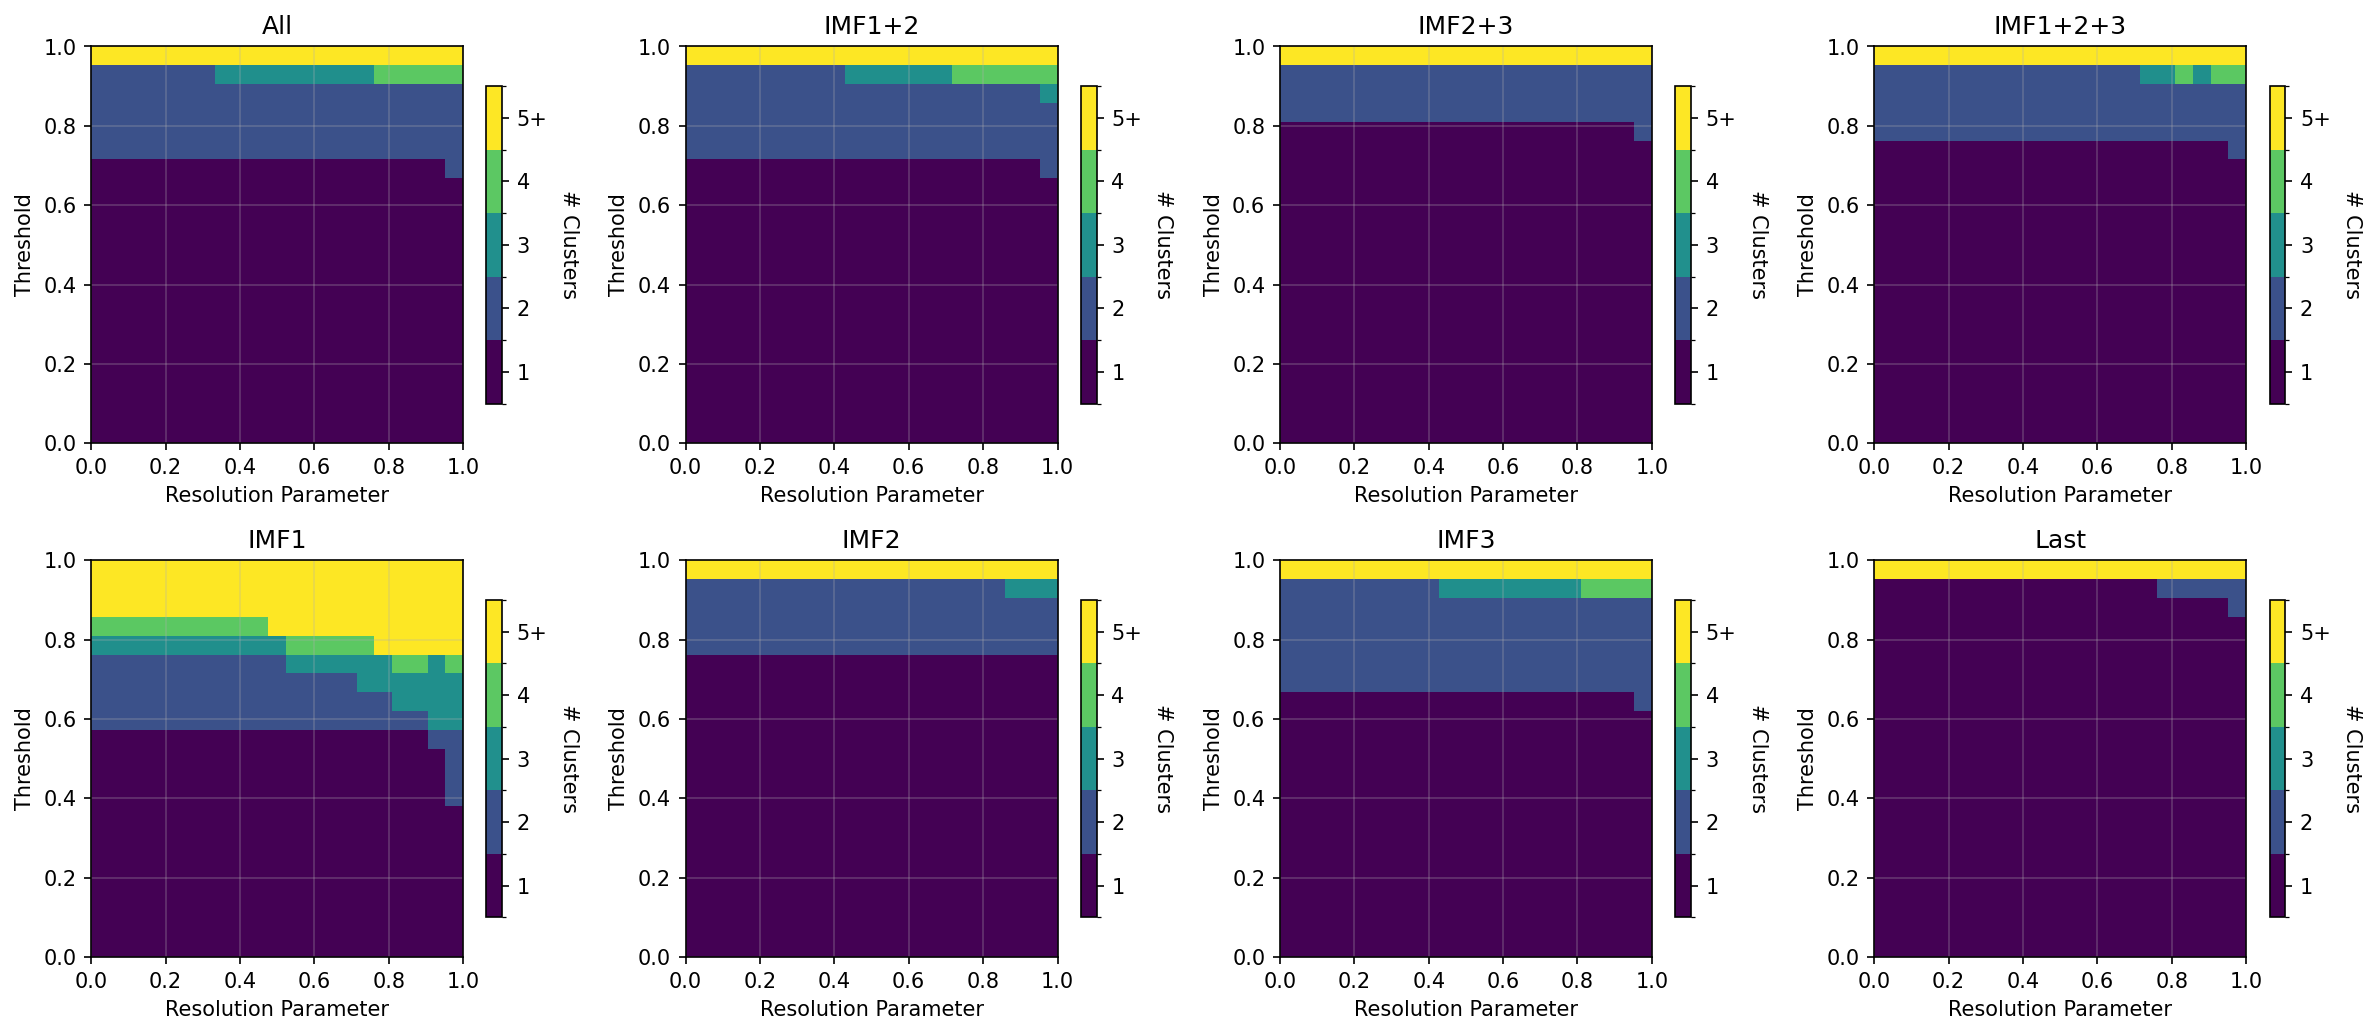

In [29]:
import matplotlib.colors as colors


# 파라미터 조합 테스트
imf_configs = [999, 12, 23, 123, 0, 1, 2, -1]
imf_labels = ['All', 'IMF1+2', 'IMF2+3', 'IMF1+2+3', 'IMF1', 'IMF2', 'IMF3', 'Last']


n_clusters = 5
cmap = plt.cm.viridis
bounds = np.arange(0.5, n_clusters + 1.5, 1)  # [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

# 2행 4열 시각화
fig, axes = plt.subplots(2, 4, figsize=(16, 7), dpi=150)
axes = axes.flatten()

for i, (imf_config, imf_label) in enumerate(zip(imf_configs, imf_labels)):
    ax = axes[i]
    
    # Heatmap 생성
    im = ax.imshow(ress[i], aspect='auto', cmap='viridis', norm=norm,
                   extent=[0, 1.0, 0., 1.], origin='lower')
    
    # 컬러바 추가
    cbar = plt.colorbar(im, ax=ax, shrink=0.8, spacing='proportional', ticks=[1, 2, 3, 4, 5])
    cbar.set_ticklabels(['1', '2', '3', '4', '5+'])
    cbar.set_label('# Clusters', rotation=270, labelpad=15)
    
    # 축 레이블과 제목
    ax.set_xlabel('Resolution Parameter')
    ax.set_ylabel('Threshold')
    ax.set_title(f'{imf_label}')
    
    # 그리드 추가
    ax.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('Output/clustering_parameter_sweep.pdf', dpi=300, bbox_inches='tight')
plt.show()

Notes
- Features use de-meaned series (subtracting the first value), consistent with the main workflow.
- Clustering uses KMeans as a lightweight default. If you prefer the Leiden graph approach from the main notebook, we can add a toggle cell that builds the adjacency from Euclidean distances and runs Leiden (requires `igraph` and `leidenalg`).
- Station names are matched via `Data/Monthly_*.txt` and `Data_final/total_results.csv`. Ensure names align (e.g., English names like `Busan`, `Incheon`).